In [95]:
import math
import numpy as np
import scipy as sp
from scipy.linalg import eig
from numpy import sin, cos, abs, exp, sqrt, arccos, pi

%matplotlib inline
import matplotlib.pyplot as plt
%config InlineBackend.figure_format ="retina"
import matplotlib as mpl
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [96]:
U = 0.5 # Kerr nonlinearity
gamma = 5e-2 # 5e-2 # Total loss rate
J = 1.0 # Tunneling
N = 500 # Number of cavities
F_list = np.linspace(0.01, 2.0, 50) # Pump
curvatures = [U, 0.4, 0.35, 0.3, 0.3, 0.3] # The constant multiplying |F|^2 in each case
Delta_matrix = [curvature*F_list**2 for curvature in curvatures]

In [98]:
def f_RK4(Delta_l, g, gamma, t_c, t_l, a):

    a_l = np.concatenate((np.zeros(1), a[:-1]))
    a_r = np.concatenate((a[1:], np.zeros(1)))

    y = -1.0j * (
        -Delta_l*a + g*abs(a)**2*a -1.0j*gamma*a - t_c*a_l - t_c*a_r + t_l
    )
    
    return y

N_t = 1e4 # Number of time steps
t_f = 1e3 # Final time
t = np.linspace(0, t_f, int(N_t))
Delta_t = t[1] - t[0]

In [103]:
insta_list = []
I_T_list = []

# Cavity-laser coupling
Delta_n_list = [2, 6, 10, 14, 18, 22]
n1 = 249

In [104]:
I_T_matrix = np.zeros((len(Delta_n_list), len(Delta_matrix[0])), dtype=np.float64)

for i_Delta_n, Delta_n in enumerate(Delta_n_list):

    Delta_list = Delta_matrix[i_Delta_n]

    print('Delta n = {:}'.format(Delta_n_list[i_Delta_n]))

    ll_list = np.zeros(len(Delta_list), dtype=np.float64)

    i_Delta = 0

    # Cavity fields
    a = np.zeros((N, int(N_t)), dtype=np.complex128)

    for F_value, Delta in zip(F_list, Delta_list):

        F = np.zeros(N, dtype=np.complex128)
        n2 = n1 + Delta_n_list[i_Delta_n]
        F[n1] = F_value
        F[n2] = F_value

        for i_t in range(len(t)-1):

            k1 = f_RK4(Delta, U, gamma, J, F, a[:, i_t])
            k2 = f_RK4(Delta, U, gamma, J, F, a[:, i_t] + k1*Delta_t/2)
            k3 = f_RK4(Delta, U, gamma, J, F, a[:, i_t] + k2*Delta_t/2)
            k4 = f_RK4(Delta, U, gamma, J, F, a[:, i_t] + k3*Delta_t)

            a[:, i_t+1] = a[:, i_t] + (k1 + 2*k2 + 2*k3 + k4)*Delta_t/6

        a[:, 0] = a[:, -1]

        # We define a parameter characterizing the light localization
        ll_list[i_Delta] = np.sum(np.abs(a[249+1:249+Delta_n, -1])**2) / np.sum(np.abs(a[:, -1])**2)
        I_T_matrix[i_Delta_n, i_Delta] = np.sum(np.abs(a[:, -1])**2)

        i_Delta += 1

    for i_ll, ll in enumerate(ll_list):
        if ll < 0.9*ll_list[0]:
            break
    insta_list.append(i_ll)

Delta n = 2
Delta n = 6
Delta n = 10
Delta n = 14
Delta n = 18
Delta n = 22


[1.00585999 0.42744462 0.14045827]
[0.99546371 0.54148213 0.23130844]


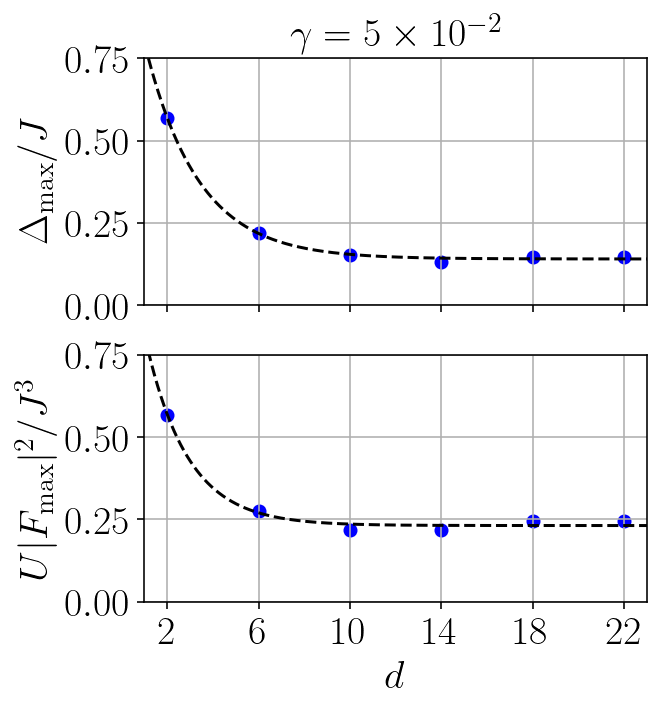

In [106]:
insta_list_Delta = []
for insta_index, insta in enumerate(insta_list):
    Delta_list = Delta_matrix[insta_index]
    insta_list_Delta.append(Delta_list[insta])

insta_list_F = []
for insta_index, insta in enumerate(insta_list):
    Delta_list = Delta_matrix[insta_index]
    insta_list_F.append(F_list[insta])

plt.rcParams["figure.figsize"] = [4.5, 5]
fig, ax = plt.subplots(2, 1)
fs = 20
ax[0].grid()
ax[1].grid()

ax[0].scatter(Delta_n_list, insta_list_Delta, color='blue')

from scipy.optimize import curve_fit

def f(x, a, b, c):
    return a*np.exp(-b*x) + c
x = np.array(Delta_n_list)
y = insta_list_Delta
popt, pcov = curve_fit(f, x, y)
print(popt)
x = np.linspace(1, 25, 1000)
ax[0].plot(x, popt[0]*np.exp(-popt[1]*x) + popt[2], '--k')

ax[1].scatter(Delta_n_list, U*np.array(insta_list_F)**2/J**3, color='blue')

def f(x, a, b, c):
    return a*np.exp(-b*x) + c
x = np.array(Delta_n_list)
y = U*np.array(insta_list_F)**2/J**3
popt, pcov = curve_fit(f, x, y)
print(popt)
x = np.linspace(1, 25, 1000)
ax[1].plot(x, popt[0]*np.exp(-popt[1]*x) + popt[2], '--k')

#ax[0].set_ylim([0.0, 1.0])
ax[0].set_ylabel(r'$\Delta_{\rm max}/J$', fontsize=fs)
ax[0].tick_params(axis='both', labelsize=fs)

#ax[1].set_ylim([0.0, 1.5])
ax[1].set_ylabel(r'$U|F_{\rm max}|^2/J^3$', fontsize=fs)
ax[1].tick_params(axis='both', labelsize=fs)

ax[0].set_xlim(1, 23)
#ax[0].set_ylim(0.1, 0.7)
ax[1].set_xlim(1, 23)
#ax[1].set_ylim(0.1, 0.7)

ax[0].set_xticklabels([])
#ax[1].set_xticklabels([])
ax[0].set_xticks([2, 6, 10, 14, 18, 22])
ax[1].set_xticks([2, 6, 10, 14, 18, 22])
ax[1].set_xlabel(r'$d$', fontsize=fs)


#ax[0].set_ylim([0.0, 0.3])
#ax[1].set_ylim([0.0, 0.3])
#ax[0].set_title(r'$\gamma=5 \times 10^{-3}J$', fontsize=fs)
#plt.savefig("Figure3_a.svg", bbox_inches='tight', dpi=600)

ax[0].set_ylim([0.0, 0.75])
ax[1].set_ylim([0.0, 0.75])
ax[0].set_title(r'$\gamma=5 \times 10^{-2}J$', fontsize=fs)
#plt.savefig("Figure3_b.svg", bbox_inches='tight', dpi=600)